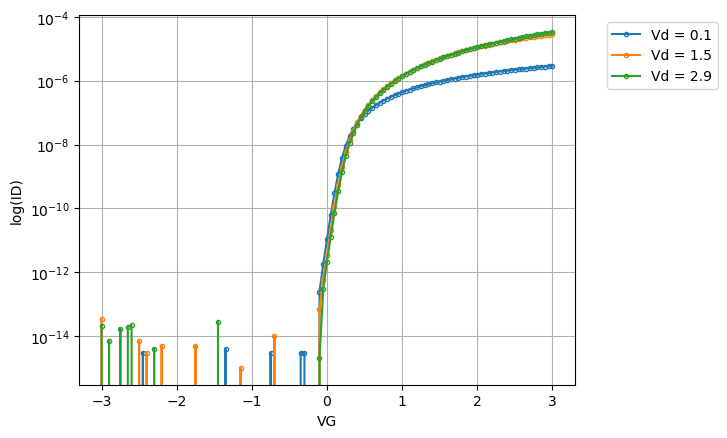

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


readfile = pd.read_csv('I_V Sweep - Unit (transfer) [251203_ALD IGZO_#1_R0C0_40_20_1(1) _ 12_8_2025 9_25_29 AM].csv',sep = ',', skiprows=266)     # CSV 파일 이름만 변경(위에 불필요한 내용 skiprows로 삭제)

df = readfile.iloc[:,1:]                                      # 읽어온 파일의 row는 다 들고오고 column은 두번째 열부터 들고옴(dataname 열 삭제)



df.columns = df.columns.str.strip()                         # column 내의 앞뒤 글자 공백 삭제

groups = df.groupby('VD')                                     # 같은 vd로 grouping

plt.figure()                                                    # plot 할 도화지를 만듬

for VD_value, group in groups:                                  # VD 값을 하나씩 꺼내서 그 VD에 해당하는 데이터를 가지고 그림을 그림
    plt.semilogy(group['VG'], group['ID'],marker='o',markerfacecolor='none',markersize=3, label=f'Vd = {VD_value}')        # semilogy는 y축을 log로 그리는 것

plt.xlabel('VG')
plt.ylabel('log(ID)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



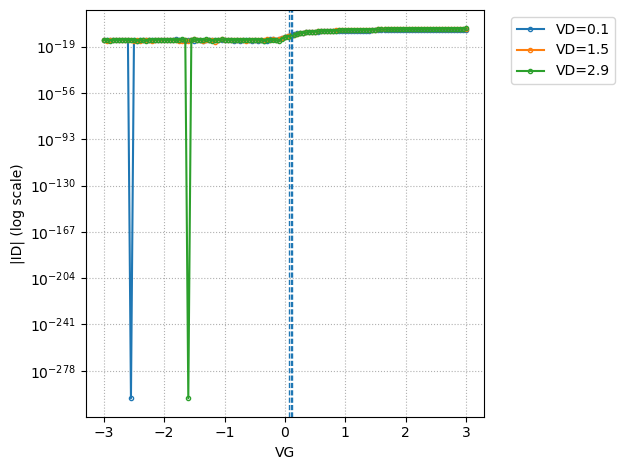

Vth @ log10(|ID|) = -10 (by VD)
VD=0.1: Vth=0.06538496627680902
VD=1.5: Vth=0.09603633354799337
VD=2.9: Vth=0.1104689344711671


In [3]:
target = -10.0  # log10(|ID|) 목표값

# ===== 2) VD별 plot + Vth 계산 =====
plt.figure()

vth_by_vd = {}  # VD별 Vth 저장

for vd, g in df.groupby('VD'):
    g = g.sort_values('VG').copy()

    VG = g['VG'].to_numpy()
    ID = g['ID'].to_numpy()

    # log10(|ID|) 계산: 0은 로그 불가 → 아주 작은 값으로 클리핑
    absID = np.abs(ID)
    absID = np.clip(absID, 1e-300, None)   # underflow 방지
    logI = np.log10(absID)

    # 곡선 그리기 (semilogy는 y축 log 스케일)
    plt.semilogy(VG, absID, marker='o', markerfacecolor='none',
                 markersize=3, label=f'VD={vd}')

    # ===== 3) target 교차 구간 탐색 + 선형 보간 =====
    diff = logI - target
    cross_idx = np.where(diff[:-1] * diff[1:] <= 0)[0]  # target을 사이에 두는 인접 점

    if len(cross_idx) == 0:
        vth_by_vd[vd] = np.nan
        continue

    # 첫 번째 crossing 사용 (원하면 마지막 crossing: cross_idx[-1])
    i = cross_idx[0]

    x0, x1 = VG[i], VG[i+1]
    y0, y1 = logI[i], logI[i+1]

    # 분모 0 방지
    if y1 == y0:
        vth = np.nan
    else:
        vth = x0 + (target - y0) * (x1 - x0) / (y1 - y0)

    vth_by_vd[vd] = vth

    # Vth 위치를 시각적으로 표시(세로선)
    if np.isfinite(vth):
        plt.axvline(vth, linestyle='--', linewidth=1)

# ===== 4) 마무리 =====
plt.xlabel('VG')
plt.ylabel('|ID| (log scale)')  # semilogy라서 log(ID) 대신 이렇게 쓰는 게 정확함
plt.grid(True, which='both', linestyle=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ===== 5) VD별 Vth 출력 =====
print("Vth @ log10(|ID|) = -10 (by VD)")
for vd in sorted(vth_by_vd.keys()):
    print(f"VD={vd}: Vth={vth_by_vd[vd]}")

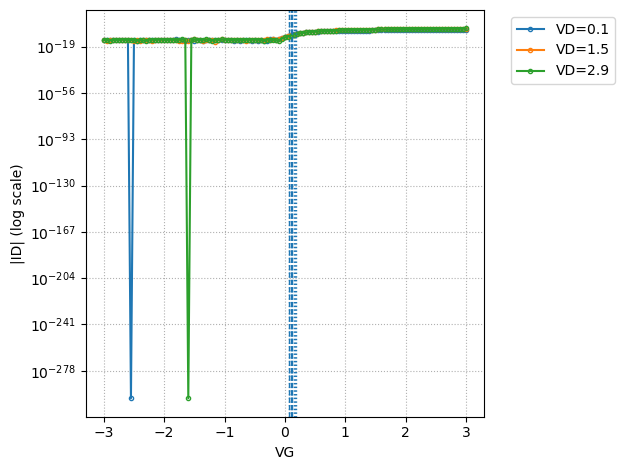

Vth @ log10(|ID|) = -10 (by VD)
VD=0.1: Vth=0.06538496627680902
VD=1.5: Vth=0.09603633354799337
VD=2.9: Vth=0.1104689344711671

SS (V/dec) between log10(|ID|)=-10 and -9 (by VD)
VD=0.1: SS=0.07740823290016151  (mV/dec: 77.40823290016151)
VD=1.5: SS=0.07838538552644975  (mV/dec: 78.38538552644975)
VD=2.9: SS=0.0778190538362559  (mV/dec: 77.8190538362559)


In [4]:
# 유효 데이터만
df = df.dropna(subset=['VD', 'VG', 'ID']).copy()

# 로그 계산용 target
TARGET_VTH = -10.0  # log10(|ID|) = -10 에서의 VG를 Vth로 정의
TARGET_SS1 = -10.0  # SS 구간 하단
TARGET_SS2 = -9.0   # SS 구간 상단 (1 decade 차이)

# =========================
# 2) 보간 함수 (log10(|ID|)=target 에서 VG 찾기)
# =========================
def interp_vg_at_logI(VG_arr, logI_arr, target_logI, pick="first"):
    """
    VG_arr, logI_arr: 같은 길이 1D 배열 (VG 정렬되어 있어야 함)
    target_logI를 가로지르는 구간을 찾아 선형보간으로 VG 반환
    pick: 'first' 또는 'last' (crossing이 여러 개인 경우 선택)
    """
    diff = logI_arr - target_logI
    idx = np.where(diff[:-1] * diff[1:] <= 0)[0]  # target을 사이에 둠
    if len(idx) == 0:
        return np.nan

    j = idx[0] if pick == "first" else idx[-1]

    x0, x1 = VG_arr[j], VG_arr[j + 1]
    y0, y1 = logI_arr[j], logI_arr[j + 1]

    if y1 == y0:
        return np.nan

    return x0 + (target_logI - y0) * (x1 - x0) / (y1 - y0)

# =========================
# 3) VD별 plot + Vth/SS 계산
# =========================
plt.figure()

vth_by_vd = {}   # VD별 Vth 저장
ss_by_vd  = {}   # VD별 SS(V/dec) 저장

for vd, g in df.groupby('VD'):
    g = g.sort_values('VG').copy()

    VG = g['VG'].to_numpy()
    ID = g['ID'].to_numpy()

    # log10(|ID|) 계산 (0 방지)
    absID = np.abs(ID)
    absID = np.clip(absID, 1e-300, None)
    logI  = np.log10(absID)

    # ---- Plot (semilogy) ----
    plt.semilogy(
        VG, absID,
        marker='o', markerfacecolor='none', markersize=3,
        label=f'VD={vd}'
    )

    # ---- Vth: log10(|ID|)=-10에서의 VG ----
    vth = interp_vg_at_logI(VG, logI, TARGET_VTH, pick="first")
    vth_by_vd[vd] = vth

    if np.isfinite(vth):
        plt.axvline(vth, linestyle='--', linewidth=1)

    # ---- SS: log10(|ID|)=-10, -9에서의 VG 각각 구해 차이(=V/dec) ----
    vg_m10 = interp_vg_at_logI(VG, logI, TARGET_SS1, pick="first")
    vg_m9  = interp_vg_at_logI(VG, logI, TARGET_SS2, pick="first")

    if np.isfinite(vg_m10) and np.isfinite(vg_m9):
        ss_v_per_dec = (vg_m9 - vg_m10)  # 1 decade 차이 → 그대로 V/dec
    else:
        ss_v_per_dec = np.nan

    ss_by_vd[vd] = ss_v_per_dec

    # 시각화(선택): -10, -9에서의 VG 표시
    if np.isfinite(vg_m10):
        plt.axvline(vg_m10, linestyle=':', linewidth=1)
    if np.isfinite(vg_m9):
        plt.axvline(vg_m9, linestyle=':', linewidth=1)

# ---- Plot 마무리 ----
plt.xlabel('VG')
plt.ylabel('|ID| (log scale)')
plt.grid(True, which='both', linestyle=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =========================
# 4) 결과 출력
# =========================
print("Vth @ log10(|ID|) = -10 (by VD)")
for vd in sorted(vth_by_vd.keys()):
    print(f"VD={vd}: Vth={vth_by_vd[vd]}")

print("\nSS (V/dec) between log10(|ID|)=-10 and -9 (by VD)")
for vd in sorted(ss_by_vd.keys()):
    print(f"VD={vd}: SS={ss_by_vd[vd]}  (mV/dec: {ss_by_vd[vd]*1e3 if np.isfinite(ss_by_vd[vd]) else np.nan})")

In [9]:
def get_group_by_vd(df, vd_target, tol=1e-9, pick_nearest=True):
    """
    df에서 vd_target에 해당하는 그룹을 반환
    - 측정 데이터에서 VD가 부동소수로 저장된 경우가 많아 isclose/nearest로 잡는 게 안전
    """
    vds = np.array(sorted(df['VD'].dropna().unique()))
    if len(vds) == 0:
        return None, np.nan

    if pick_nearest:
        vd_sel = vds[np.argmin(np.abs(vds - vd_target))]
    else:
        # 정확히 일치하는 VD만 허용
        m = np.isclose(vds, vd_target, atol=tol, rtol=0)
        if not np.any(m):
            return None, np.nan
        vd_sel = vds[m][0]

    g = df[np.isclose(df['VD'], vd_sel, atol=tol, rtol=0)].copy()
    return g, vd_sel


def vg_at_id_for_vd(df, vd_target, id_target=None, logid_target=None,
                    pick="first", tol_vd=1e-9):
    """
    VD=vd_target에서
      - id_target(단위 A)를 주면 log10(|ID|)로 바꿔서 보간
      - 또는 logid_target(예: -10)을 직접 주면 그 값에서 VG 보간
    반환: (vd_selected, vg_interp)

    pick: crossing이 여러 개면 "first" 또는 "last"
    """
    if (id_target is None) == (logid_target is None):
        raise ValueError("id_target 또는 logid_target 중 하나만 넣어야 합니다.")

    g, vd_sel = get_group_by_vd(df, vd_target, tol=tol_vd, pick_nearest=True)
    if g is None or len(g) < 2:
        return np.nan, np.nan

    # VG 정렬
    g = g.dropna(subset=['VG','ID']).sort_values('VG')
    VG = g['VG'].to_numpy()
    ID = g['ID'].to_numpy()

    # log10(|ID|) (0 방지)
    absID = np.clip(np.abs(ID), 1e-300, None)
    logI = np.log10(absID)

    # 타겟 logID
    target_logI = np.log10(np.abs(id_target)) if logid_target is None else float(logid_target)

    # (당신이 이미 만든) 선형보간 함수 재사용
    vg_interp = interp_vg_at_logI(VG, logI, target_logI, pick=pick)
    return vd_sel, vg_interp


# ============================
# 사용 예시
# ============================

# 예1) VD=0.1V에서 ID=1e-10A 일 때 VG?
vd_sel, vg = vg_at_id_for_vd(df, vd_target=0.1, id_target=6.89e-7, pick="first")
print(f"VD={vd_sel:.6g} V,  ID=1e-10 A (logID=-10) -> VG={vg}")

VD=0.1 V,  ID=1e-10 A (logID=-10) -> VG=1.2662161344390404
